# Circuit test script
This script tests the resistor network calculation modules on simple electrical circuits against known solution

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy import sparse
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.spatial.distance import euclidean
import pandas as pd
from decimal import Decimal

In [2]:
class Solve:
    def __init__(self, X):
        self.G=X
        self.N=self.G.order()
        self.nR=self.G.number_of_edges()
        
    def conductances(self):
        #Extract the values of the resistors from the graph 
        #and build a nR x nR matrix
        mat=sparse.spdiags(np.asarray(list((#
            nx.get_edge_attributes(self.G, "weight").values())))#
                           , 0, self.nR, self.nR)
        return sparse.csc_matrix(mat)
    
    def incidence(self):
        #Builds the incidence matrix from the graph
        mat= np.transpose(nx.incidence_matrix(self.G, oriented=1)) 

        return mat
    
    def voltages(self):
        #Get the potential values from the nodes 
        #and build a vector
        vec=np.array(list(nx.get_node_attributes(self.G,#
                                                 "potential").values()))
        return vec

    
    def currents(self):
        #Combines the other functions to get the 
        #currents trough the resistors
        A=-(self.conductances() @ Orientation(self))
        return  A @ self.voltages()
    


#Solve(Gitter).currents()   

In [3]:
def Orientation(G):
    #Code Snippet that is used for orienting the edges 
    #according to the applied voltage 
    #for positive currents as in most of literature
    Mat=G.incidence()
    V=G.voltages()
    for x in range(np.shape(Mat)[0]):
        Y=[]
        for y in range(np.shape(Mat)[1]):
            if Mat[x,y] !=0:
                Y.append(y)
        Mat[x,Y[0]]=-np.sign(V[Y[0]]-V[Y[1]])
        Mat[x,Y[1]]=-Mat[x,Y[0]]
    return Mat

## Wheatstone bridge

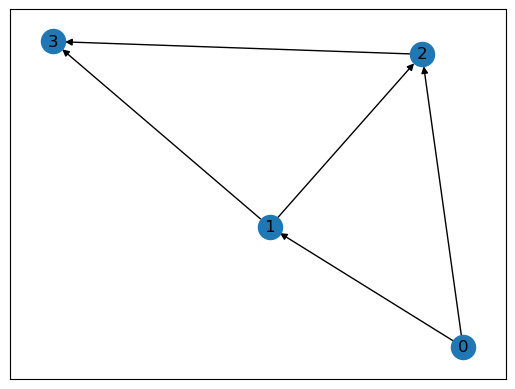

In [4]:
#see calculation by hand in 'Theory' section
W=nx.DiGraph()
W.add_edges_from([(0,1),(0,2),(1,2),(2,3),(1,3)])

nx.draw_networkx(W)

W.add_nodes_from(range(4))
W.nodes[0]['potential'] = 10
W.nodes[1]['potential'] = 6
W.nodes[2]['potential'] = 4.5
W.nodes[3]['potential'] = 0


W.edges[0,1]['weight'] = 1/0.5
W.edges[0,2]['weight'] = 1/1.375
W.edges[1,2]['weight'] = 1/0.3
W.edges[2,3]['weight'] = 1/0.5
W.edges[1,3]['weight'] = 1/2

In [5]:
Wheat=Solve(W)
-Wheat.currents() 
#Note: For convenience this impementation re-orients 
#edges according to the voltage - not by the index
#Therefore a negative sign is needed to match the 
#orientation in the calculation by hand

array([-8., -4., -5., -3., -9.])

### Demtröder Exercise 2.4

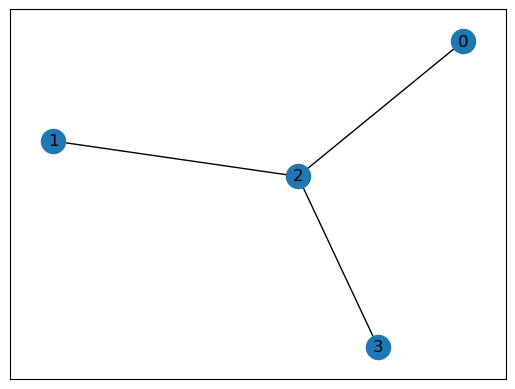

In [6]:
#see Demtröder page 77
C=nx.Graph()
C.add_nodes_from(range(4))
C.add_edges_from([(1,2),(3,2),(2,0)])

nx.draw_networkx(C)


C.nodes[0]['potential'] = 0
C.nodes[1]['potential'] = 10
C.nodes[2]['potential'] = 2.6
C.nodes[3]['potential'] = 4

C.edges[1,2]['weight'] = 1/20
C.edges[3,2]['weight'] = 1/5
C.edges[2,0]['weight'] = 1/4

In [7]:
Dem=Solve(C)
Dem.currents()

array([0.65, 0.37, 0.28])

## Electronic Tutorials Exercise

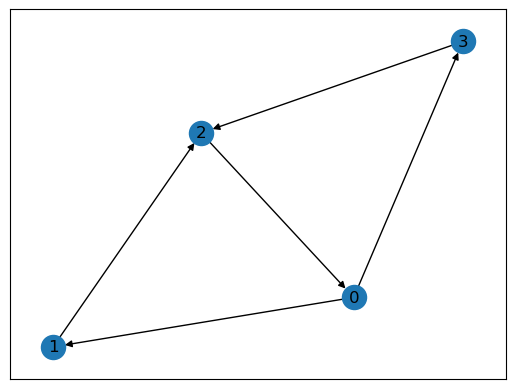

In [8]:
#see https://www.electronics-tutorials.ws/dccircuits/dcp_6.html
A=nx.DiGraph()
A.add_edges_from([(0,1),(0,3),(2,0),(1,2),(3,2)])

nx.draw_networkx(A)

A.add_nodes_from(range(4))
A.nodes[0]['potential'] = 0
A.nodes[1]['potential'] = 10
A.nodes[2]['potential'] = 11.44
A.nodes[3]['potential'] = 20

for (u, v) in A.edges():
    A.edges[u,v]['weight'] = 1/10000
A.edges[1,2]['weight'] = 1/10
A.edges[3,2]['weight'] = 1/20
A.edges[2,0]['weight'] = 1/40

In [9]:
Tut=Solve(A)
Tut.currents()[4]

0.286

## 3D cubus

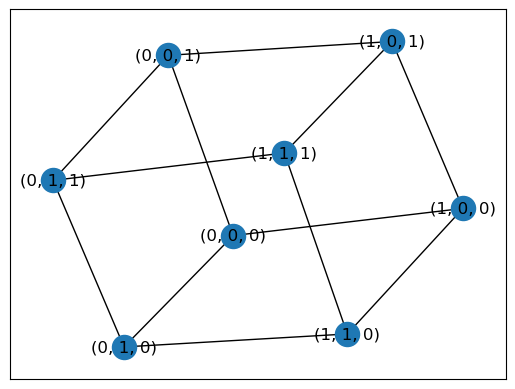

In [10]:
#Initialize Lattice
x1=2
x2=2
x3=2
K = nx.grid_graph(dim=(x1,x2,x3)) #3D Grid

# 3D Resistances

for (u, v) in K.edges():
    K.edges[u,v]['weight'] = 1/1 # Unit resistance

K.nodes[0,0,0]['potential'] = 0
K.nodes[1,1,1]['potential'] = 12

K.nodes[1,0,0]['potential'] = 24/5
K.nodes[0,1,0]['potential'] = 24/5
K.nodes[0,0,1]['potential'] = 24/5

K.nodes[0,1,1]['potential'] = 12-24/5
K.nodes[1,0,1]['potential'] = 12-24/5
K.nodes[1,1,0]['potential'] = 12-24/5
#Draw
nx.draw_networkx(K)

In [11]:
Cube=Solve(K)
np.sum(Cube.currents()[0:3])

14.399999999999999